# Detrending
(teaching: 25 minutes, exercises: 10 minutes)

### Questions:
- "How do we eliminate trends in our data?"
- "Why are linear models useful?s"

### Objectives:
- "Detrend image data with a linear model"
- "Use a linearized quadratic model to fit second order effects"

### Keypoints:
- "Linear models are useful to represent the images in a concise and computationally expedient manner"
- "Linearized models are used to fit more complex models using the same mathematical framework"

In [1]:
import os.path as op
import dipy.data as dpd
remote, local = dpd.fetch_stanford_t1()
T1_file = op.join(local, 't1.nii.gz')

Dataset is already in place. If you want to fetch it again please first remove the folder /home/jovyan/.dipy/stanford_hardi 


In [2]:
import nibabel as nib

T1w_img = nib.load(T1_file)
T1w_data = T1w_img.get_data()

We will use the segmentation algorithm we saw before to focus only on the part of the image that contains the brain:

In [3]:
from dipy.segment.mask import median_otsu
T1w_data, mask = median_otsu(T1w_data)

/opt/conda/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


### Using the spatial relationships in image processing

In the next example of image processing , the
spatial relationships between voxels will be made rather explicit. We will use
the spatial coordinates to remove spatial trends from the data.

### Our data contains spatial bias

As we saw in the last part, MRI data often contains spatial biases. Some of
these may be due to physiological factors, such as differences in the T1
time-constant between different parts of the brain. But some of these represent
"nuisance factors" that should be eliminated as a first step in the analysis of
the image.

For example, the image is brighter in the back of the head of this participant
than in the front. This often happens when the head is placed closer to the
measurement coils that are at the bottom of the coil, closer to the occipital
cortex. We can also see that the center of the brain is darker than the more
external parts, also presumably due to the distance of these parts from the
measurement coils.

To model this spatial bias and remove it, we will assume that changes across the
entire extent of the image are due to bias.


### Modeling linear bias and detrending

A linear spatial bias can be thought of as another 3D volume that coexists in
the same space as our data. This bias field can be modeled as a combination of
of biases on the x, y and z dimensions.

We'll use the `np.meshgrid` function to create volumes that contain the
3D functions:

$vol(x,y,z) = x \\
vol(x,y,z) = y \\
vol(x,y,z) = z \\$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
x,y,z = np.meshgrid(range(-T1w_data.shape[0]//2, T1w_data.shape[0]//2),
                    range(-T1w_data.shape[1]//2, T1w_data.shape[1]//2),
                    range(-T1w_data.shape[2]//2, T1w_data.shape[2]//2), indexing='ij')

To clarify, let's also create a little function that will help us view these
volumes:

In [6]:
def show_volumes(volume_list):
    fig, ax = plt.subplots(1, len(volume_list))
    for idx in range(len(volume_list)):
        this = volume_list[idx]
        ax[idx].matshow(this[:, :, this.shape[-1]//2], cmap='bone')
        ax[idx].axis('off')
    fig.set_size_inches([14, 5])
    return fig

For example, the following should show sections through the T1-weighted data, as
well as through each one of these volumes:

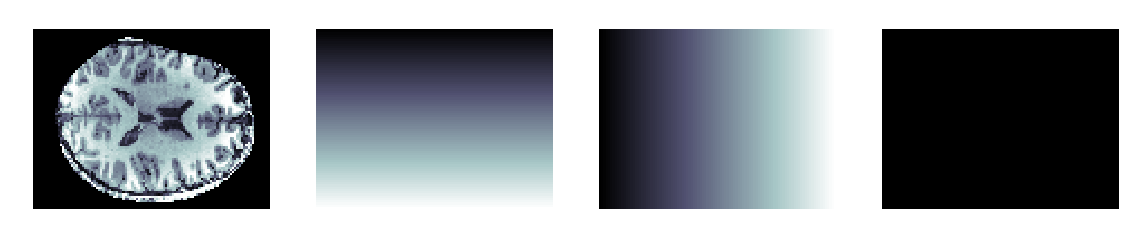

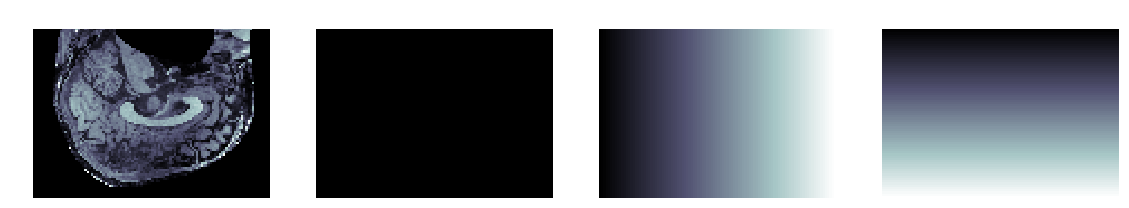

In [7]:
fig1 = show_volumes([T1w_data, x, y, z])
fig2 = show_volumes([T1w_data.T, x.T, y.T, z.T])

You can see that in the top row, the `x` volume changes gradually along the
right-left dimension of the participants head. The `y` volume changes gradually
along the anterior-posterior dimension. The `z` volume doesn't change at all
(why?). Similarly, in the second row, the `z` and `y` volumes change, while the
`x` volume remains constant along this entire slice.

Mathematically, the bias field can be described as a linear combination of
these three volumes:

$data_{measured} = data_{true} + bias$

$bias = data_{measured} - data_{true}$

where

$bias = \beta_1 x + \beta_2 y + \beta_3 z $

Another way of saying this is that all linear bias fields are spanned by the
basis set comprising `x`, `y` and `z`.

Next, we are going to make a simple assumption that in the lack of any spatial
bias, the data would have a more-or-less constant value across space. That is,
we assume that for unbiased data,

$\beta_1 = \beta_2 = \beta_3 = 0$.

This seems like a strange assumption to make, but it makes sense when you think
of the fact that we expect the brain to be more or less symmetrical (it's not
supposed to be much brighter in any particular direction), and given the spatial
scale of the functions we are using for debiasing.

Even if you feel uncomfortable with this assumption, you might want to remember
that the T1-weighted measurement is just that: a non-quantitative weighted
measurement that is affected by T1, but not directly reflective of. If
subsequent image processing operations are made simpler by this detrending, it
might be worth ignoring actual biological differences (e.g. white matter with T1
that is slightly different in frontal cortex, relative to other lobes) in the
service of these other steps.

But this allows us to rewrite the above function as:

$data_{measured} = \beta_1 x + \beta_2 y + \beta_3 z$

Then, To find the values of ${\bf \beta}$ we start by unraveling the data and the
regressors into one-dimensional vector form, using the `np.ravel` function:

In [8]:
regressors = np.vstack([np.ravel(x), np.ravel(y), np.ravel(z)]).T
data = np.ravel(T1w_data.ravel())
data.shape, regressors.shape

((652536,), (652536, 3))

The shape of the unravelled data is the product of the `x`, `y` and `z`
dimensions of the data

The problem we are now trying to solve can be written as the following set of
linear equations:

$\begin{pmatrix}
T1_{0,0,0} \\
T1_{0,0,1} \\
\vdots \\
T1_{0, 0, N_z} \\
T1_{0, 1, 0} \\
T1_{0,1,1} \\
\vdots \\
T1_{1,0,0} \\
T1_{1,0,1} \\
\vdots \\
T1_{N_x, N_y, N_z} \end{pmatrix} =
\begin{pmatrix}
x_{0,0,0} & y_{0,0,0} & z_{0,0,0} \\
x_{0,0,1} & y_{0,0,1} & z_{0,0,1}\\
\vdots & \vdots & \vdots \\
x_{0, 0, N_z} & y_{0, 0, N_z} & z_{0, 0, N_z} \\
x_{0, 1, 0} & y_{0, 1, 0} & z_{0, 1, 0} \\
x_{0,1,1} & y_{0,1,1} & z_{0,1,1} \\
\vdots & \vdots & \vdots \\
x_{1,0,0} & y_{1,0,0} & z_{1,0,0} \\
x_{1,0,1} & y_{1,0,1} & z_{1,0,1}\\
\vdots & \vdots & \vdots \\
x_{N_x, N_y, N_z} & y_{N_x, N_y, N_z} & z_{N_x, N_y, N_z}
\end{pmatrix}
\begin{pmatrix} \beta_1 \\ \beta_2 \\ \beta_3 \end{pmatrix}
$

These equations can be solved for \\({\bf \beta}\\) with an Ordinary Least
Squares solution. This is implemented in `scipy.linalg` as `lstsq`:

In [9]:
import scipy.linalg as la
# la.lstsq?  # Get help about this function

In [10]:
solution = la.lstsq(regressors, data)

Because the solution is a tuple with a variety of information about the
solution, we'll just extract out only the first element:

In [11]:
beta_hat = solution[0]

Inverting the equation gives us an estimate of the linear trend, but it still
has the unravelled shape:

In [12]:
linear_trend = np.dot(regressors, beta_hat)
linear_trend.shape

(652536,)

We reshape it back to the correct shape, and remove it from the data for a
detrended volume, which we can examine side-by-side with the original data:

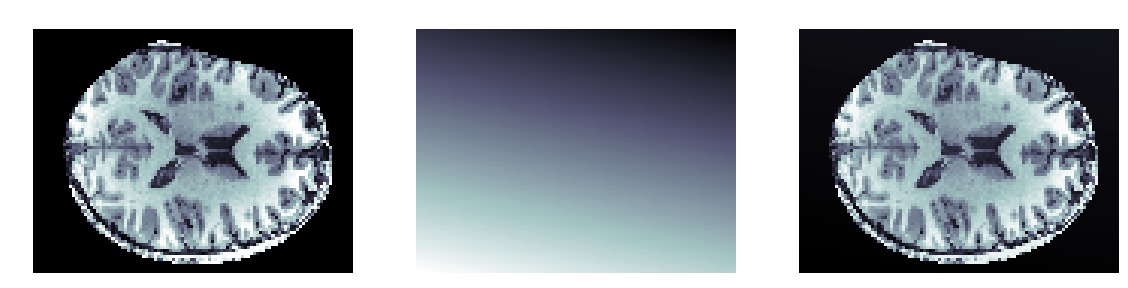

In [13]:
linear_trend = np.reshape(linear_trend, T1w_data.shape)
T1w_linear_detrend = T1w_data - linear_trend
fig = show_volumes([T1w_data, linear_trend, T1w_linear_detrend])

Let's write a function to codify this entire process:

In [14]:
def detrend(data, regressors):
    regressors = np.vstack([r.ravel() for r in regressors]).T
    solution = la.lstsq(regressors, data.ravel())
    beta_hat = solution[0]
    trend = np.dot(regressors, beta_hat)
    detrended = data - np.reshape(trend, data.shape)
    return detrended, beta_hat

This simplifies the process to:

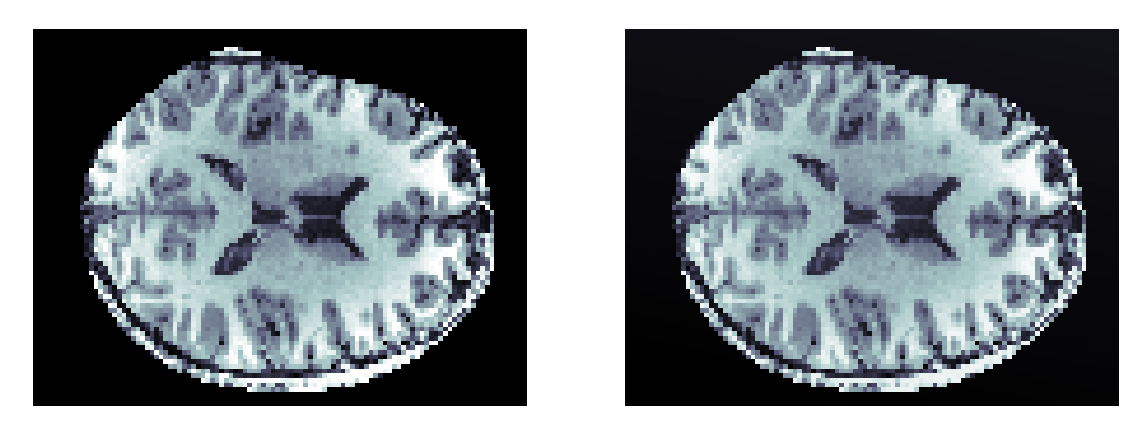

In [15]:
T1w_linear_detrend, beta_hat = detrend(T1w_data, [x, y, z])
fig = show_volumes([T1w_data, T1w_linear_detrend])

> ### "Detrending"
>
> Note that "detrending" is often used in a similar manner in neuroimaging to
> remove temporal biases. Here we are rather performing a spatial detrending
> operation
>

One way to understand the nature of the bias field is to examine the values of
the coefficients that were found in the solution to the linear equations.

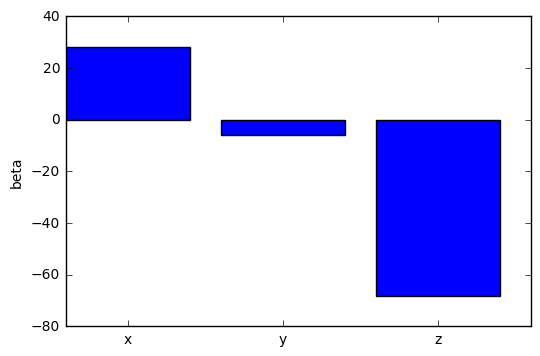

In [16]:
fig, ax = plt.subplots()
ax.bar(np.arange(beta_hat.shape[0]), beta_hat)
ax.set_xticks(np.arange(beta_hat.shape[0]) + 0.4)
ax.set_xticklabels(['x', 'y', 'z'])
ax.set_ylabel('beta')

We can see that there is almost no up-down bias field. Indeed, there is some
anterior-posterior bias and an even more substantial superior-inferior bias.

> ## What can we do with the remaining interior-exterior bias?
>
> Examining the images, we can see that the detrending has removed some of the
> biases in the data, but there is still a clear interior-exterior bias.s
> What could we do to help mitigate this additional bias?

### Removing additional bias with a linearized model

The linear model we have seen so far does manage to get rid of some of the bias,
but what can we do to get rid of the interior-exterior bias?

To do so, we add to our bias-field model quadratic functions, to augment the
linear trends that we already have included:

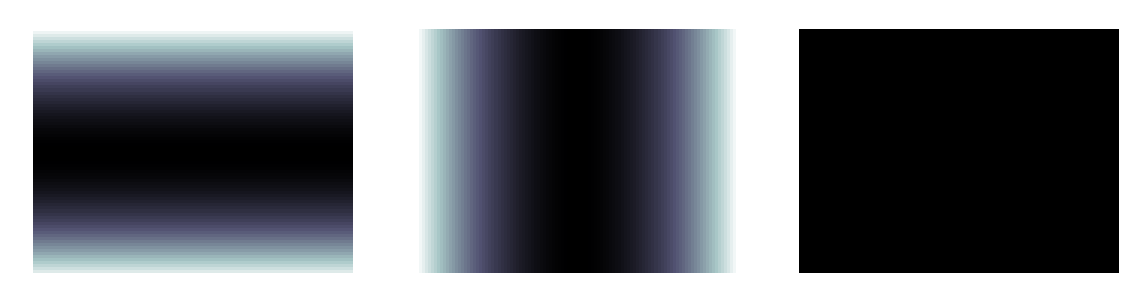

In [17]:
x_sq = x**2
y_sq = y**2
z_sq = z**2
fig = show_volumes([x_sq, y_sq, z_sq])

These functions allow us to model second order trends in the data. Perfect for
modeling trends like a center-out brightening.

This model has more parameters and a wider design matrix:

$$ data = \beta_1 {\bf x} + \beta_2 {\bf y} + \beta_3 {\bf z} +
          \beta_4 {\bf x^2} + \beta_5 {\bf y^2} + \beta_6 {\bf z^2} $$

$$
\begin{pmatrix} {\bf T1w} \\ \vdots \end{pmatrix} =
\begin{pmatrix}
{\bf x} && {\bf y} && {\bf z} && {\bf x^2} && {\bf y^2} && {\bf z^2}
\\
\vdots && \vdots && \vdots && \vdots && \vdots && \vdots
\end{pmatrix}
\begin{pmatrix} \beta_1 \\ \beta_2 \\ \beta_3 \\ \beta_4 \\ \beta_5 \\ \beta_6
\end{pmatrix}
$$

We sometimes call this kind of a model a "linearized" model, because we have
inserted non-linear equations into the form of the general linear model.

Using our `detrend` function, we can construct and solve the augmented model:

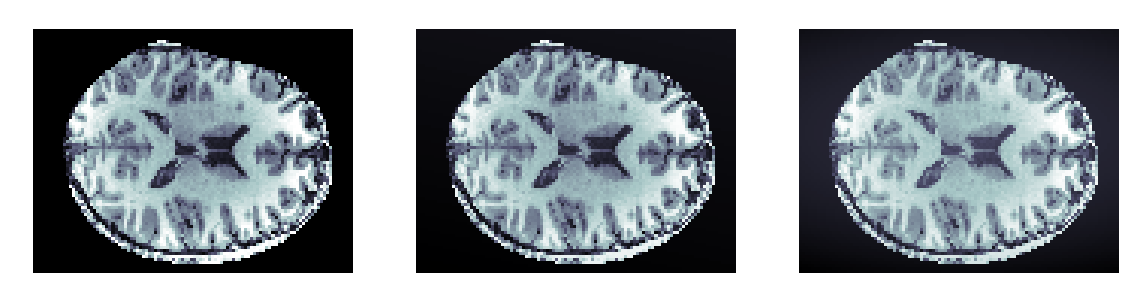

In [18]:
T1w_data_detrended_quad, beta_hat = detrend(T1w_data, [x, y, z, x_sq, y_sq, z_sq])
fig = show_volumes([T1w_data, T1w_linear_detrend, T1w_data_detrended_quad])

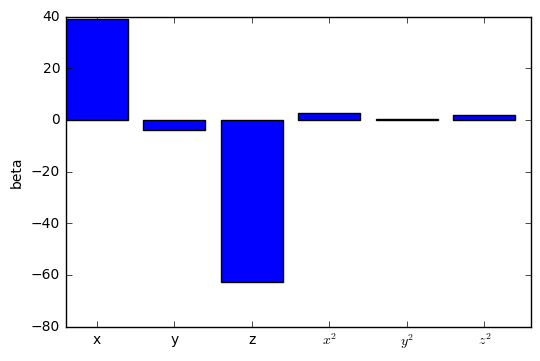

In [19]:
fig, ax = plt.subplots()
ax.bar(np.arange(beta_hat.shape[0]), beta_hat)
ax.set_xticks(np.arange(beta_hat.shape[0]) + 0.4)
ax.set_xticklabels(['x', 'y', 'z', '$x^2$', '$y^2$', '$z^2$'])
ax.set_ylabel('beta')

### Should we keep going?

We could augment this model of the bias further with additional functions
($x^3$, $x^4$, etc.), but should we really keep going? At some point, the
functions that we use will start picking up the interesting spatial variation in
the data, rather than the large-scale bias. So, we can't just keep going with
this.

> ### When is it enough?
>
> In some conditions, you might be able to determine empirically when you
> should stop the process of augmenting a model. A variation of this principle
> is demonstrated in the temporal domain in [this paper](http://journal.frontiersin.org/article/10.3389/fnins.2013.00247/full)
>
